In [1]:
# MIT License
# Copyright (c) 2020 Adam Tibi (https://linkedin.com/in/adamtibi/ , https://adamtibi.net)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import load_model
from common_variables import *

In [2]:
pred_interval = 128 # Predict every n minutes
pred_size = 30 # Prediction length into the future
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
df = pd.read_csv(test_time_series_path, dayfirst = True, index_col=['Date'], parse_dates=['Date'], usecols=['Date','HLAvg','MA','Returns'])[-batch_size*40:]

In [4]:
scaler = joblib.load(scaler_path)
df['Scaled'] = scaler.transform(df[['Returns']].values)

In [5]:
model = load_model(model_path)

In [6]:
scaled = df['Scaled'].values

# Create empty column to store the multi predictions
df["Pred_Close_From"] =  np.nan
df["Pred_Close_To"] = np.nan

# Cache the column indices 
pred_close_from_col_index = df.columns.get_loc('Pred_Close_From')
pred_close_to_col_index = df.columns.get_loc('Pred_Close_To')

ma_col_index = df.columns.get_loc('MA')
predictions_for_plot = []
df_len = df.shape[0]
for i in range(window_size, df_len - pred_size, pred_interval):
    X = [scaled[i-window_size:i]]
    y = []
    y_ma = df.iloc[i - 1, ma_col_index]
    for _ in range(pred_size):
        X = np.asarray(X)
        X = np.reshape(X, (1, window_size, 1))
        y_pred_scaled = model.predict(X)
        y_return = scaler.inverse_transform(y_pred_scaled)
        #y_ma = y_ma * (1 + y_return) # Arithmetic Returns
        y_ma = y_ma * np.exp(y_return) # Log Returns
        y.append(float(y_ma))
        # Remove first item in the list
        X = np.delete(X, 0)
        # Add the new prediction to the end
        X = np.append(X, y_pred_scaled)

    df.iloc[i, pred_close_from_col_index] = y[0]
    df.iloc[i, pred_close_to_col_index] = y[-1]
    y_padded = np.pad(y, (i, df_len - pred_size - i), mode='constant', constant_values=np.nan)
    df_plot = pd.Series(data=y_padded,index=df.index)

    predictions_for_plot.append(df_plot)

df

,HLAvg,MA,Returns,Scaled,Pred_Close_From,Pred_Close_To
Date,,,,,,
2020-09-03 23:40:00,1.326575,1.326606,-0.000002,0.609159,NaN,NaN
2020-09-03 23:41:00,1.326555,1.326589,-0.000013,0.607134,NaN,NaN
2020-09-03 23:42:00,1.326560,1.326573,-0.000013,0.607184,NaN,NaN
2020-09-03 23:43:00,1.326565,1.326565,-0.000006,0.608418,NaN,NaN
2020-09-03 23:44:00,1.326575,1.326568,0.000003,0.609998,NaN,NaN
...,...,...,...,...,...,...
2020-09-04 20:55:00,1.327765,1.327645,0.000006,0.610540,NaN,NaN
2020-09-04 20:56:00,1.328065,1.327686,0.000031,0.615276,NaN,NaN
2020-09-04 20:57:00,1.328145,1.327736,0.000038,0.616411,NaN,NaN


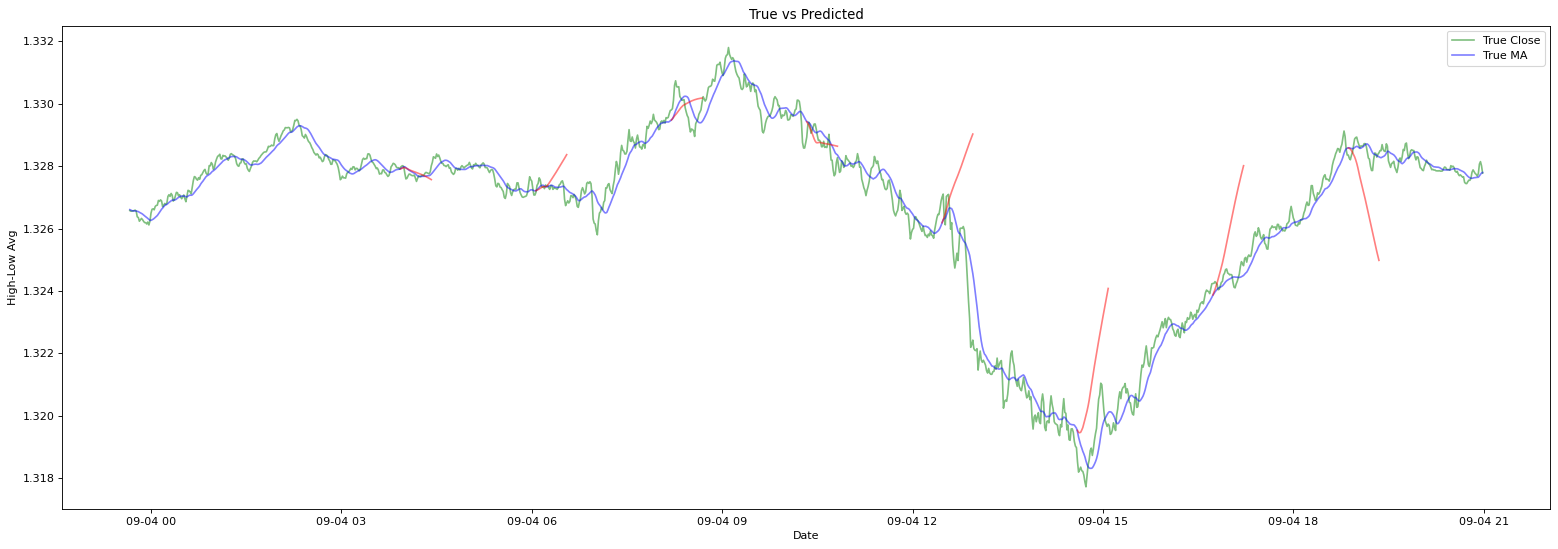

In [7]:
plt.figure(figsize=(24, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df['HLAvg'], color = 'green', label = 'True Close', alpha=0.5)
plt.plot(df['MA'], color = 'blue', label = 'True MA', alpha=0.5)
for i in range(len(predictions_for_plot)):
    plt.plot(predictions_for_plot[i], color = 'red', alpha=0.5)
plt.title('True vs Predicted')
plt.xlabel('Date')
plt.ylabel('High-Low Avg')
plt.legend()
plt.show()